In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 32
num_itr = 20
K = 100
max_inner = 50
train_depth = 20
adam_lr = 0.01
M = 0.05 * jnp.array(np.random.randn(n, n))
P = 0.15 * jnp.eye(len(M)) + M.T @ M

In [3]:
def get_x_sol(q):
    return JLA.inv(P) @ q
batch_get_x_sol = jax.jit(jax.vmap(get_x_sol, in_axes=-1, out_axes=-1))

In [4]:
def Jacobi_itr(max_itr, q):
    x = jnp.zeros((n, K))
    D = jnp.diag(P.diagonal())
    Dinv = JLA.inv(D)
    A = -Dinv @ (P - D)
    b = Dinv @ q
    for i in range(max_itr):
        x = A @ x + b
    return x

In [5]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [6]:
def comp_mse(max_itr):
    q = jnp.array(np.random.randn(n, K))
    x_sol = batch_get_x_sol(q)
    x_hat = Jacobi_itr(max_itr, q)
    return jnp.sum(batch_get_dot(x_hat - x_sol))/K

In [7]:
Jacobi_mse = [comp_mse(i+1) for i in range(num_itr)]

In [8]:
df = pd.DataFrame()
df["Iteration"] = range(num_itr)
df["Jacobi method"] = np.array(Jacobi_mse)

In [11]:
@partial(jax.jit, static_argnums=0)
def DU_PSOR(max_itr, q, omega, T):
    x = jnp.zeros((n, K))
    D = jnp.diag(P.diagonal())
    Dinv = JLA.inv(D)
    A = -Dinv @ (P - D)
    b = Dinv @ q
    for i in range(max_itr):
        k = (i % T) + 1
        x += omega[k] * (A @ x + b - x)
    return x

In [12]:
def loss(x_fixed, max_itr, q, T, omega):
    x_hat = DU_PSOR(max_itr, q, omega, T)
    return jnp.sum(batch_get_dot(x_hat - x_fixed))/K

In [13]:
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_fixed, max_itr, q, T, step_num, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_fixed, max_itr, q, T, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(omega, T):
    opt_state = opt_init(omega)
    for itr in trange(train_depth, leave=False):
        for i in range(max_inner):
            q = jnp.array(np.random.randn(n, K))
            x_sol = batch_get_x_sol(q)
            value, opt_state = step(x_sol, itr+1, q, T, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [14]:
def comp_mse_DUPSOR(max__itr, omega, T):
    q = jnp.array(np.random.randn(n, K))
    x_sol = batch_get_x_sol(q)
    x_hat = DU_PSOR(max__itr, q, omega, T)
    return jnp.sum(batch_get_dot(x_hat - x_sol))/K

In [15]:
T = 1
omega_init = jnp.ones(T)
omega_trained = train(omega_init, T)

  0%|          | 0/20 [00:00<?, ?it/s]

loss:9.187345995087526e-09  

In [16]:
df["DU-PSOR iteration T={}".format(T)] = [float(comp_mse_DUPSOR(i+1, omega_trained, T)) for i in range(num_itr)]

In [17]:
T = 2
omega_init = jnp.ones(T)
omega_trained = train(omega_init, T)

  0%|          | 0/20 [00:00<?, ?it/s]

loss:1.0302277253515513e-08 

In [18]:
df["DU-PSOR iteration T={}".format(T)] = [float(comp_mse_DUPSOR(i+1, omega_trained, T)) for i in range(num_itr)]

In [19]:
T = 8
omega_init = jnp.ones(T)
omega_trained = train(omega_init, T)

  0%|          | 0/20 [00:00<?, ?it/s]

loss:2.020349339215688e-11  

In [20]:
df["DU-PSOR iteration T={}".format(T)] = [float(comp_mse_DUPSOR(i+1, omega_trained, T)) for i in range(num_itr)]

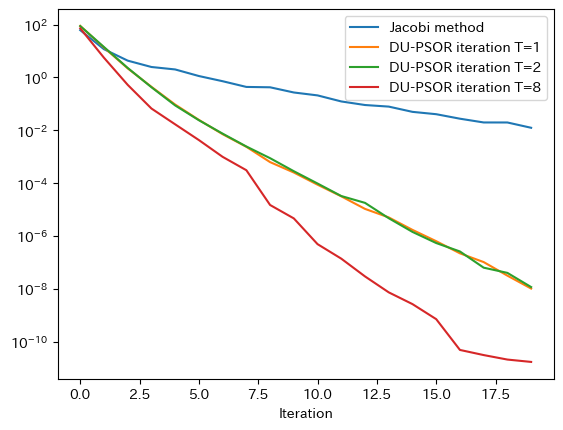

In [21]:
df.plot(x = df.columns[0], y = df.columns[1:])
plt.yscale("log")